# Does producing a joint graph add information instead of destroying it?

If we have two cell types, where there is a clear difference between them in one modality, but not the other, how well can different methods combine their information?

To look at this we'll simulate some data, look at some plots.

## Normalization of similarity matrices

$$
P_{i, j} = 
\begin{cases} 
      \frac{W_{i, j}}{2\sum_{k \neq i}{W_{i, k}}} & i \neq j \\ 
      \frac{1}{2} & j = i \\
\end{cases}
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import pairwise_distances
import scanpy as sc
from scipy import sparse

import matplotlib.pyplot as plt

One of the tools we'll use is Similarity Network Fusion (https://doi.org/10.1038/nmeth.2810) as used by CiteFuse (https://doi.org/10.1093/bioinformatics/btaa282)
.

In [3]:
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
numpy2ri.activate()

SNFtool = importr("SNFtool")

def affinity(dists):
    """Calculate affinity matrix from distances.
    
    Normalization of distance metric used by SNF.
    """
    return np.array(SNFtool.affinityMatrix(dists))

def snf(mtxs, K=20, t=20):
    """
    Params
    ------
    mtxs
        Affinity matrices
    K
        Number of neigbors to keep for S
    t
        Number of iterations
    """
    return np.array(SNFtool.SNF(mtxs, K=K, t=t))

# Simple dataset

In [37]:
data1, cat1 = datasets.make_blobs(n_samples=[1000, 500], n_features=50, shuffle=False)
data2, cat2 = datasets.make_blobs(n_samples=[500, 500, 500], n_features=50, shuffle=False)

adata = sc.AnnData(
    data1,
    obs={"cat1": pd.Categorical(cat1).astype(str), "cat2": pd.Categorical(cat2).astype(str)},
    obsm={"alt_mode": data2},
)

In [38]:
adata.obsp["dists1"] = pairwise_distances(adata.X)
adata.obsp["dists2"] = pairwise_distances(adata.obsm["alt_mode"])

In [39]:
adata.obsp["affinity1"] = affinity(adata.obsp["dists1"])
adata.obsp["affinity2"] = affinity(adata.obsp["dists2"])

In [40]:
# This is pretty slow
%time adata.obsp["fused"] = snf([adata.obsp["affinity1"], adata.obsp["affinity2"]], t=1)

CPU times: user 10.7 s, sys: 55.9 ms, total: 10.7 s
Wall time: 10.7 s


### Calculating graph layouts of connectivities

In [8]:
sc.tl.draw_graph(adata, obsp="affinity1", key_added_ext="1")
sc.tl.draw_graph(adata, obsp="affinity2", key_added_ext="2")
sc.tl.draw_graph(adata, obsp="fused", key_added_ext="fused")

... storing 'cat1' as categorical
... storing 'cat2' as categorical


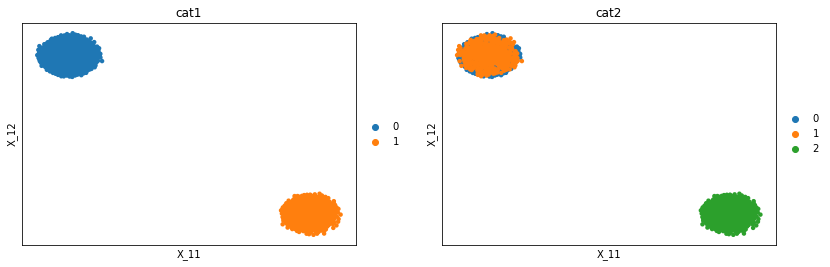

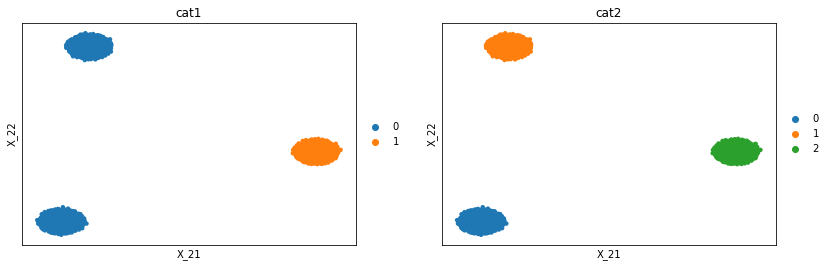

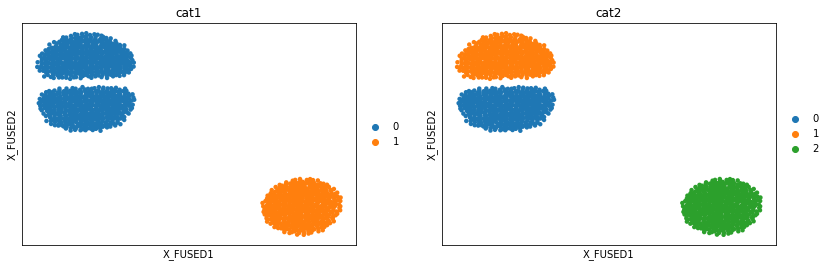

In [9]:
sc.pl.embedding(adata, "X_draw_graph_1", color=["cat1", "cat2"])
sc.pl.embedding(adata, "X_draw_graph_2", color=["cat1", "cat2"])
sc.pl.embedding(adata, "X_draw_graph_fused", color=["cat1", "cat2"])

In [47]:
adata.obsp["mean"] = (adata.obsp["affinity1"] + adata.obsp["affinity2"]) / 2
sc.tl.draw_graph(adata, obsp="mean", key_added_ext="mean")
sc.pl.embedding(adata, "X_draw_graph_mean", color="cat2", size=10)

In [10]:
?sc.pl.embedding

Note that the fused graph does not retain information from the more structured 2nd modality.

However, if we just 

In [11]:
adata.uns["neighbors"] = {"connectivities_key": "fused"}

In [12]:
adata

AnnData object with n_obs × n_vars = 1500 × 50
    obs: 'cat1', 'cat2'
    uns: 'draw_graph', 'cat1_colors', 'cat2_colors', 'neighbors'
    obsm: 'alt_mode', 'X_draw_graph_1', 'X_draw_graph_2', 'X_draw_graph_fused'
    obsp: 'dists1', 'dists2', 'affinity1', 'affinity2', 'fused'

In [13]:
adata.obsp["connectivities"] = adata.obsp["fused"]

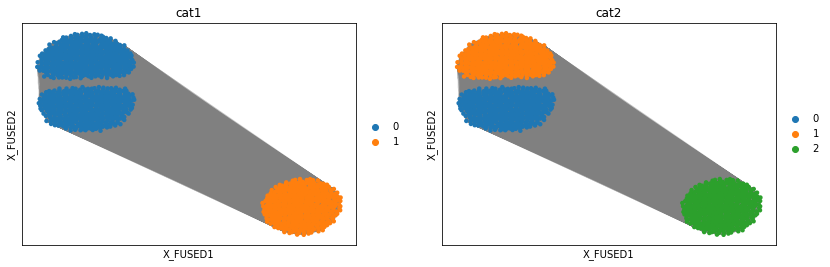

In [14]:
sc.pl.embedding(adata, "X_draw_graph_fused", color=["cat1", "cat2"], edges=True)

# simpler

In [15]:
data1, cat1 = datasets.make_blobs(n_samples=[1000, 500], n_features=50, shuffle=False)
data2, cat2 = datasets.make_blobs(n_samples=[500, 500, 500], n_features=50, shuffle=False)

adata = sc.AnnData(
    data1,
    obs={"cat1": pd.Categorical(cat1).astype(str), "cat2": pd.Categorical(cat2).astype(str)},
    obsm={"alt_mode": data2},
)

In [16]:
sc.pp.neighbors(adata, use_rep="X", key_added="neighbors1")
sc.pp.neighbors(adata, use_rep="alt_mode", key_added="neighbors2")

In [17]:
adata.obsp["fused"] = snf(
    [adata.obsp["neighbors1_connectivities"].toarray(), adata.obsp["neighbors2_connectivities"].toarray()],
    t=1,
    K=15,
)

In [18]:
adata

AnnData object with n_obs × n_vars = 1500 × 50
    obs: 'cat1', 'cat2'
    uns: 'neighbors1', 'neighbors2'
    obsm: 'alt_mode'
    obsp: 'neighbors1_distances', 'neighbors1_connectivities', 'neighbors2_distances', 'neighbors2_connectivities', 'fused'

In [19]:
adata.obsp["fused"] = adata.obsp["neighbors1_connectivities"] + adata.obsp["neighbors2_connectivities"]

In [21]:
sc.tl.draw_graph(adata, obsp="neighbors1_connectivities", key_added_ext="1")
sc.tl.draw_graph(adata, obsp="neighbors2_connectivities", key_added_ext="2")
sc.tl.draw_graph(adata, obsp="fused", key_added_ext="fused")

... storing 'cat1' as categorical
... storing 'cat2' as categorical


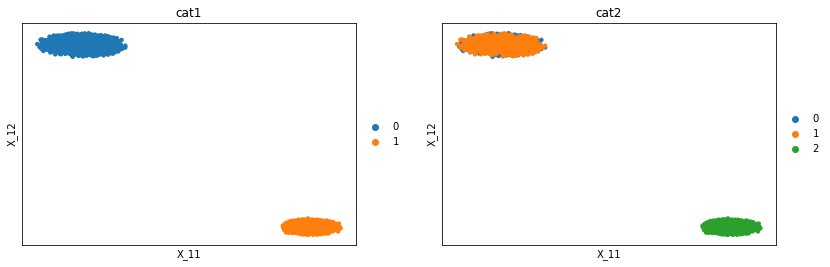

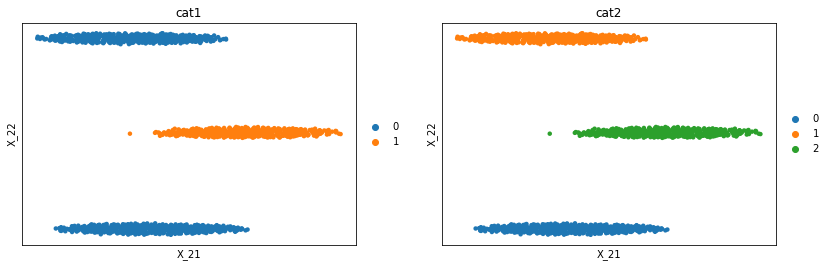

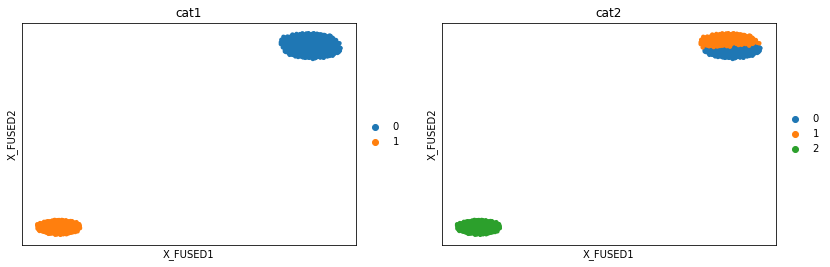

In [22]:
sc.pl.embedding(adata, "X_draw_graph_1", color=["cat1", "cat2"])
sc.pl.embedding(adata, "X_draw_graph_2", color=["cat1", "cat2"])
sc.pl.embedding(adata, "X_draw_graph_fused", color=["cat1", "cat2"])

Plot edges between points, somewhat quickly

In [ ]:
fig, ax = plt.subplot()
sc.pl.embedding(adata, "X_draw_graph_fused", color=["cat1", "cat2"], ax=ax, show=False)


In [ ]:
def make_edges():

# Ability to predict observations

Looking at the ability to predict cells by their neighbors in the other graph.

**Is this what you meant? Going back, you had mentioned using the feature space?**

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
lr = LogisticRegression()

In [43]:
lr.fit(adata.obsp["affinity1"], np.arange(adata.n_obs))

LogisticRegression()

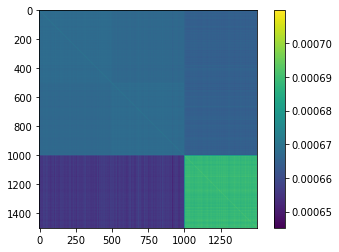

In [44]:
plt.imshow(lr.predict_proba(adata.obsp["affinity2"]))
plt.colorbar()

In [45]:
lr_rev = LogisticRegression()
lr_rev.fit(adata.obsp["affinity2"], np.arange(adata.n_obs))

LogisticRegression()

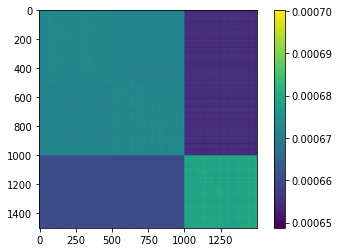

In [46]:
plt.imshow(lr_rev.predict_proba(adata.obsp["affinity1"]))
plt.colorbar()

In [34]:
sc.tl.draw_graph(adata, obsp="affinity1", key_added_ext="1")
sc.tl.draw_graph(adata, obsp="affinity2", key_added_ext="2")
sc.tl.draw_graph(adata, obsp="fused", key_added_ext="fused")

KeyError: 'affinity1'

In [ ]:
SNFtool.affinityMatrix(d1)

In [ ]:
res = snf([d1, d2], t=5)

In [ ]:
adata = sc.AnnData(pts1, obs={"cat": pd.Categorical(cats2).map(str)}, obsm={"alt_measure": pts2})

In [ ]:
adata.obsp["d1"] = pairwise_distances(pts1)
adata.obsp["d2"] = pairwise_distances(pts2)

In [ ]:
adata.obsp["a1"] = np.array(SNFtool.affinityMatrix(adata.obsp["d1"]))
adata.obsp["a2"] = np.array(SNFtool.affinityMatrix(adata.obsp["d2"]))

In [ ]:
sc.tl.draw_graph(adata, obsp="a1", key_added_ext="1")
sc.tl.draw_graph(adata, obsp="a2", key_added_ext="2")

In [21]:
adata

AnnData object with n_obs × n_vars = 1000 × 50
    obs: 'cat'
    uns: 'draw_graph'
    obsm: 'alt_measure', 'X_draw_graph_fa', 'X_draw_graph_1', 'X_draw_graph_2'
    obsp: 'd1', 'd2', 'a1', 'a2'

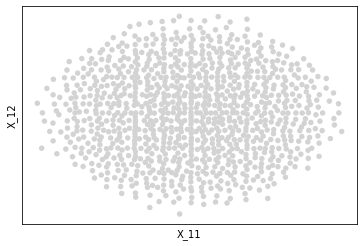

In [22]:
sc.pl.embedding(adata, basis="X_draw_graph_1")

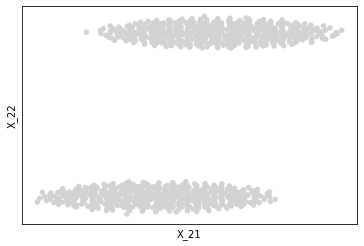

In [23]:
sc.pl.embedding(adata, basis="X_draw_graph_2")

In [24]:
adata.obsp["fused"] = np.array(snf([adata.obsp["d1"], adata.obsp["d1"]]))

In [26]:
sc.tl.draw_graph(adata, obsp="fused", key_added_ext="fused")

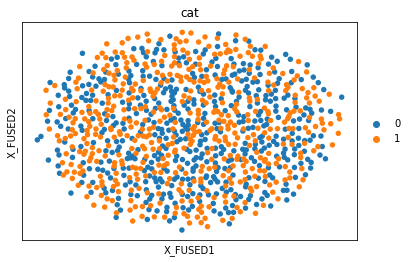

In [30]:
sc.pl.embedding(adata, "X_draw_graph_fused", color="cat")

In [27]:
adata

AnnData object with n_obs × n_vars = 1000 × 50
    obs: 'cat'
    uns: 'draw_graph'
    obsm: 'alt_measure', 'X_draw_graph_fa', 'X_draw_graph_1', 'X_draw_graph_2', 'X_draw_graph_fused'
    obsp: 'd1', 'd2', 'a1', 'a2', 'fused'

In [27]:
np.array(res)

array([[5.00000000e-01, 5.92528391e-05, 4.45876943e-04, ...,
        8.09413979e-05, 1.58386841e-04, 2.99858624e-04],
       [5.92528391e-05, 5.00000000e-01, 6.53669887e-05, ...,
        1.92806395e-03, 1.09268057e-04, 2.58158006e-05],
       [4.45876943e-04, 6.53669887e-05, 5.00000000e-01, ...,
        4.09259607e-05, 1.39809418e-04, 4.11227931e-05],
       ...,
       [8.09413979e-05, 1.92806395e-03, 4.09259607e-05, ...,
        5.00000000e-01, 5.87513488e-05, 1.12568829e-04],
       [1.58386841e-04, 1.09268057e-04, 1.39809418e-04, ...,
        5.87513488e-05, 5.00000000e-01, 3.44997163e-04],
       [2.99858624e-04, 2.58158006e-05, 4.11227931e-05, ...,
        1.12568829e-04, 3.44997163e-04, 5.00000000e-01]])

In [23]:
?SNFtool.SNF

Still simple, just showing that it doesn't fuck up the easy stuff

In [51]:
data1, cat1 = datasets.make_blobs(n_samples=[1000, 500], n_features=50, shuffle=False)
data2, cat2 = datasets.make_blobs(n_samples=[500, 500, 500], n_features=50, shuffle=False)

adata = sc.AnnData(
    data1,
    obs={"cat1": pd.Categorical(cat1).astype(str), "cat2": pd.Categorical(cat2).astype(str)},
    obsm={"alt_mode": data2},
)

In [52]:
adata.obsp["dists1"] = pairwise_distances(adata.X)
adata.obsp["dists2"] = pairwise_distances(adata.obsm["alt_mode"])

In [ ]:
adata.obsp["affinity1"] = np.array(SNFtool.affinityMatrix(adata.obsp["dists1"]))
adata.obsp["affinity2"] = np.array(SNFtool.affinityMatrix(adata.obsp["dists2"]))
adata.obsp["fused"] = snf([adata.obsp["dists1"], adata.obsp["dists1"]])
adata.obsp["fused_t-1"] = snf([adata.obsp["dists1"], adata.obsp["dists1"]], t=1)

In [ ]:
sc.tl.draw_graph(adata, obsp="affinity1", key_added_ext="1")
sc.tl.draw_graph(adata, obsp="affinity2", key_added_ext="2")
sc.tl.draw_graph(adata, obsp="fused", key_added_ext="fused")

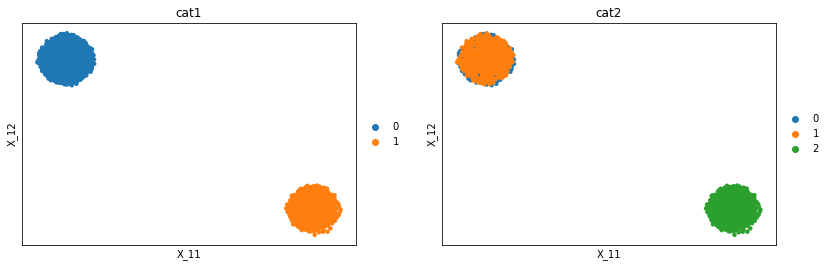

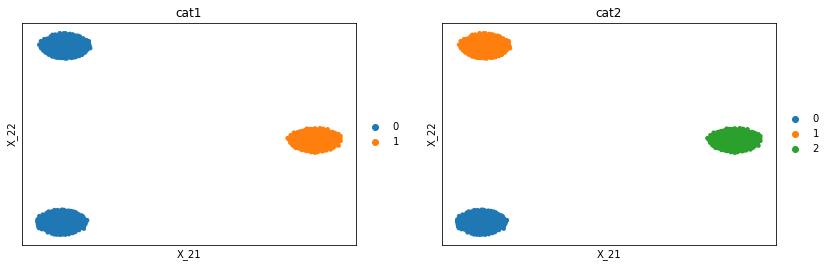

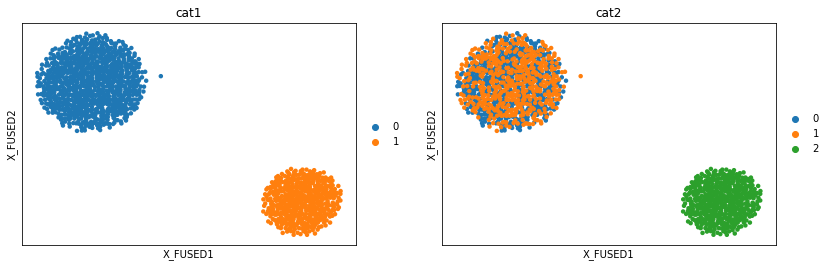

In [54]:
sc.pl.embedding(adata, "X_draw_graph_1", color=["cat1", "cat2"])
sc.pl.embedding(adata, "X_draw_graph_2", color=["cat1", "cat2"])
sc.pl.embedding(adata, "X_draw_graph_fused", color=["cat1", "cat2"])
sc.pl.embedding(adata, "X_draw_graph_fused_t-1", color=["cat1", "cat2"])

In [57]:
adata.obsm["both"] = np.hstack([adata.X, adata.obsm["alt_mode"]])
adata.obsp["affinityboth"] = np.array(SNFtool.affinityMatrix(pairwise_distances(adata.obsm["both"])))

In [59]:
sc.tl.draw_graph(adata, key_added_ext="both", obsp="affinityboth")

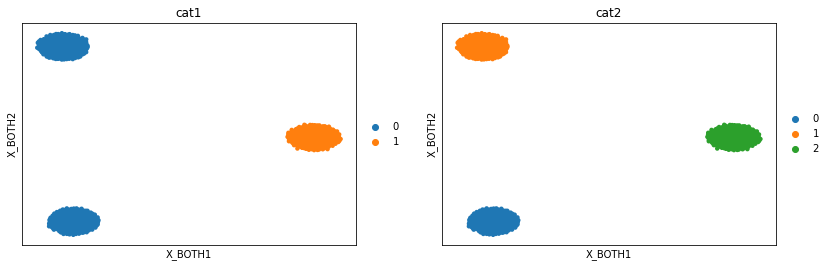

In [60]:
sc.pl.embedding(adata, "X_draw_graph_both", color=["cat1", "cat2"])

In [70]:
from sklearn.linear_model import LogisticRegression

In [73]:
lr = LogisticRegression()

In [76]:
lr.fit(adata.obsp["affinity1"], np.arange(adata.n_obs))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

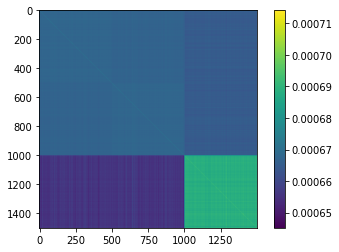

In [90]:
plt.imshow(lr.predict_proba(adata.obsp["affinity2"]))
plt.colorbar()

In [87]:
lr_rev = LogisticRegression()
lr_rev.fit(adata.obsp["affinity2"], np.arange(adata.n_obs))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

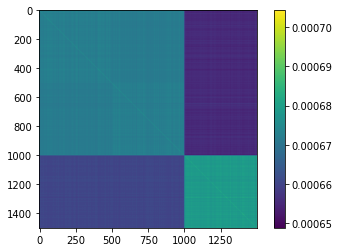

In [91]:
plt.imshow(lr_rev.predict_proba(adata.obsp["affinity1"]))
plt.colorbar()

In [61]:
adata.obsp["inverse_corr_dist"] = 1 - pairwise_distances(adata.obsm["both"], metric="cosine")

In [62]:
sc.tl.draw_graph(adata, obsp="inverse_corr_dist", key_added_ext="inv_dist")

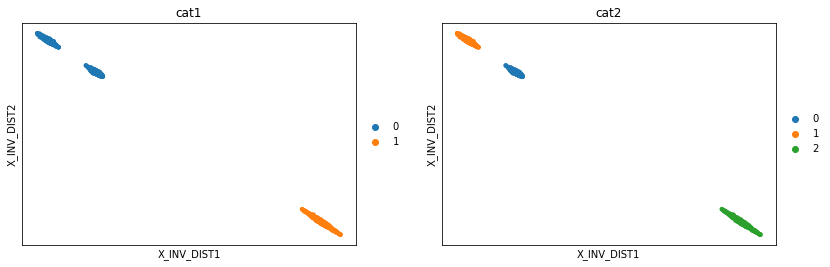

In [63]:
sc.pl.embedding(adata, "X_draw_graph_inv_dist", color=["cat1", "cat2"])